# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Цель: спрогнозировать, уйдёт ли клиент из банка в ближайшее время. Для этого необходимо построить модель  с предельно большим значением F1-меры, метрику необходимо довести до 0.59. 

Задачи:
1. Загрузить и подготовить данные. 
2.  Исследовать баланс классов, обучить модель без учёта дисбаланса. 
3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.
4. Провести финальное тестирование.

Имеется файл с данными. Описание:

RowNumber – индекс строки в данных;
CustomerId – уникальный идентификатор клиента;
Surname – фамилия;
CreditScore – кредитный рейтинг;
Geography – страна проживания;
Gender – пол;
Age – возраст;
Tenure – сколько лет человек является клиентом банка;
Balance – баланс на счёте;
NumOfProducts – количество продуктов банка, используемых клиентом;
HasCrCard – наличие кредитной карты;
IsActiveMember – активность клиента;
EstimatedSalary – предполагаемая зарплата.

Целевым фактором является Exited – факт ухода клиента.

## Подготовка данных

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm

In [217]:
df=pd.read_csv("/datasets/Churn.csv")

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [219]:
display(df.head(15))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [220]:
df['Exited'].unique()
number_subs_exit = df['Exited'].value_counts()

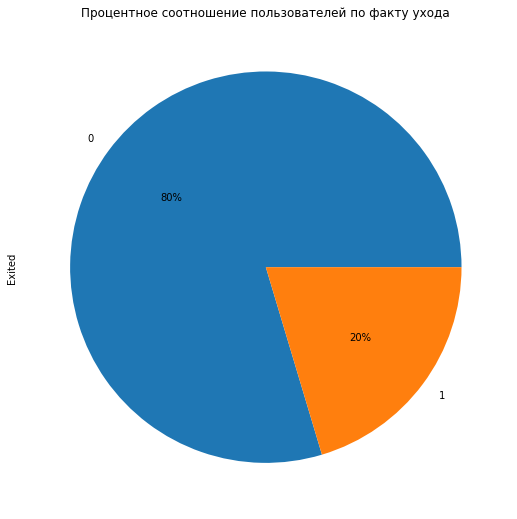

In [221]:
df['Exited'].value_counts().plot( kind = 'pie', y = number_subs_exit,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по факту ухода');

In [222]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [223]:
number_subs_geo = df['Geography'].value_counts()
print (number_subs_geo)

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


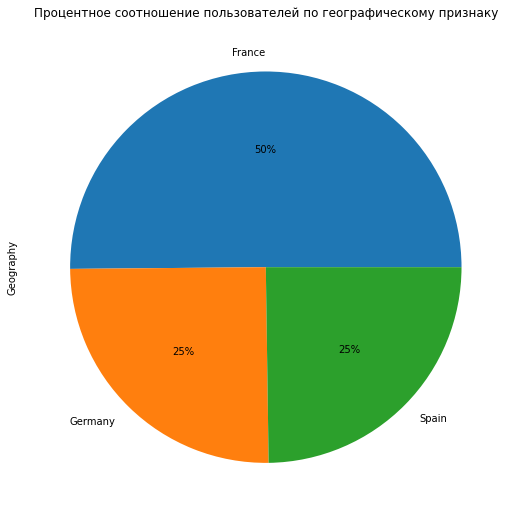

In [224]:
df['Geography'].value_counts().plot( kind = 'pie', y = number_subs_geo,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по географическому признаку');

In [225]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [226]:
number_subs_gender = df['Gender'].value_counts()
print (number_subs_gender)

Male      5457
Female    4543
Name: Gender, dtype: int64


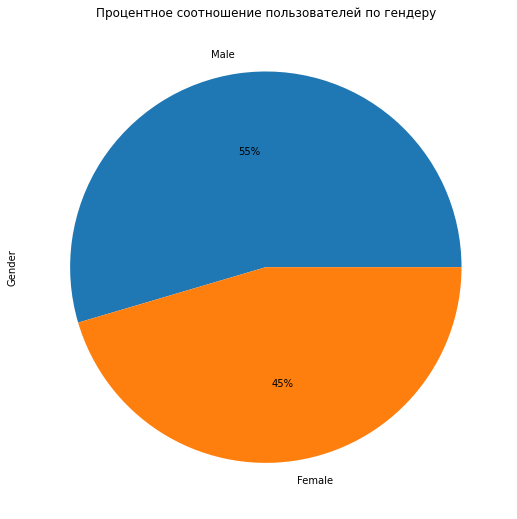

In [227]:
df['Gender'].value_counts().plot( kind = 'pie', y = number_subs_gender,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по гендеру');

In [228]:
df['NumOfProducts'].unique()

array([1, 3, 2, 4])

In [229]:
number_subs_num = df['NumOfProducts'].value_counts()
print (number_subs_num)

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64


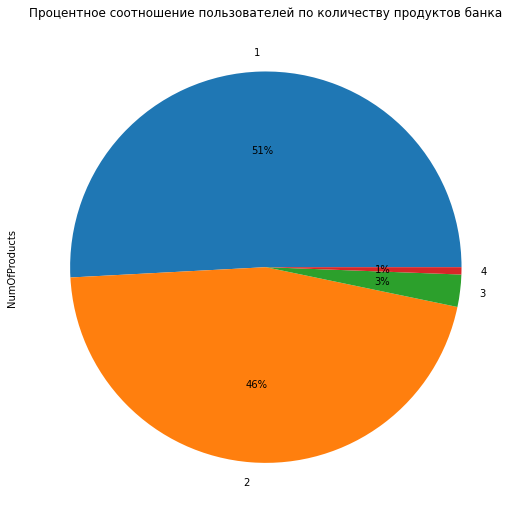

In [230]:
df['NumOfProducts'].value_counts().plot( kind = 'pie', y = number_subs_num,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по количеству продуктов банка');

In [231]:
df['HasCrCard'].unique()

array([1, 0])

In [232]:
number_subs_numcreditcards = df['HasCrCard'].value_counts()
print (number_subs_numcreditcards )

1    7055
0    2945
Name: HasCrCard, dtype: int64


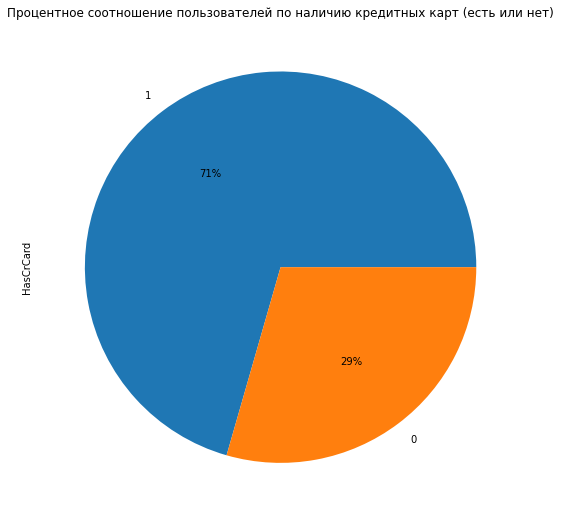

In [233]:
df['HasCrCard'].value_counts().plot( kind = 'pie', y = number_subs_numcreditcards,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по наличию кредитных карт (есть или нет)');

In [234]:
df['IsActiveMember'].unique()

array([1, 0])

In [235]:
number_subs_numactive= df['IsActiveMember'].value_counts()
print (number_subs_numactive)

1    5151
0    4849
Name: IsActiveMember, dtype: int64


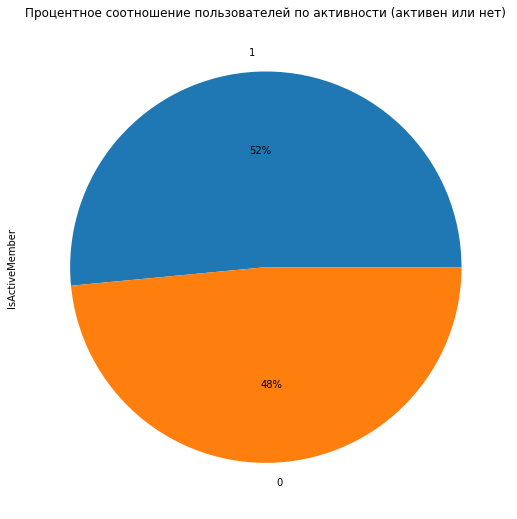

In [236]:
df['IsActiveMember'].value_counts().plot( kind = 'pie', y = number_subs_numactive,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по активности (активен или нет)');

Имеются пропуски в Tenure (сколько лет человек является клиентом банка). Посмотрим распределение данных в зависимости от других колонок в таблицах.

In [237]:
def fill_na_with_random_mean(df, Tenure):
    mean_value = df[Tenure].mean()
    std_deviation = df[Tenure].std()
    null_count = df[Tenure].isnull().sum()
    random_values = np.random.normal(loc=mean_value, scale=std_deviation, size=null_count)
    df.loc[df[Tenure].isnull(), Tenure] = random_values

In [238]:
fill_na_with_random_mean(df, 'Tenure')

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [240]:
df['Tenure'].unique()

array([ 2.        ,  1.        ,  8.        ,  7.        ,  4.        ,
        6.        ,  3.        , 10.        ,  5.        ,  9.        ,
        0.        , -0.67457486,  4.60395509,  5.35335061,  6.78901802,
        3.89366878,  6.70765166,  2.44748951,  5.71591134,  5.84458128,
        3.1619672 ,  1.02279507,  6.08651806,  5.49510261,  5.11327095,
        5.5813231 , 10.42191521,  5.37581487,  7.8426069 ,  0.99539927,
        5.28620242, -0.05731021,  9.39732912,  0.5262933 ,  8.12954012,
        0.82629965,  6.44698263,  3.56156631,  5.69096733,  4.23503935,
        6.23155413,  6.69886309,  3.28185808,  1.87443838, 10.43456046,
        9.95242033,  6.80050518,  0.52754178,  4.00899069,  7.51850895,
        4.29740683,  4.38167201,  3.14144975,  2.24553712,  0.17001535,
       10.14010941,  2.53267919,  4.28329554,  4.77967058,  2.51572236,
        3.67344888,  8.79597992,  4.41897764,  3.81853558, -1.02924339,
        3.37218918,  2.89033767,  7.61755465,  7.13443188,  4.27

<AxesSubplot:xlabel='Tenure'>

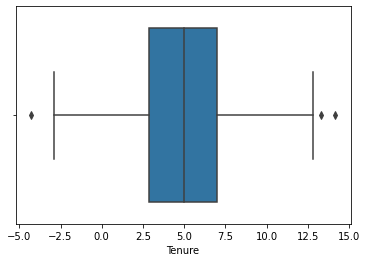

In [241]:
sns.boxplot(x=df['Tenure'])

<AxesSubplot:xlabel='CreditScore'>

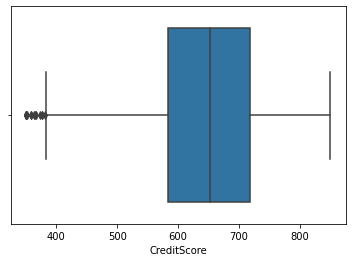

In [242]:
sns.boxplot(x=df['CreditScore'])

<AxesSubplot:xlabel='EstimatedSalary'>

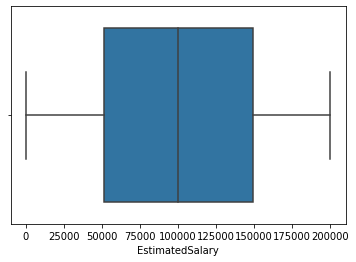

In [243]:
sns.boxplot(x=df['EstimatedSalary'])

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [245]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int64  
 1   CustomerId         10000 non-null  int64  
 2   Surname            10000 non-null  object 
 3   CreditScore        10000 non-null  int64  
 4   Age                10000 non-null  int64  
 5   Tenure             10000 non-null  float64
 6   Balance            10000 non-null  float64
 7   NumOfProducts      10000 non-null  int64  
 8   HasCrCard          10000 non-null  int64  
 9   IsActiveMember     10000 non-null  int64  
 10  EstimatedSalary    10000 non-null  float64
 11  Exited             10000 non-null  int64  
 12  Geography_Germany  10000 non-null  uint8  
 13  Geography_Spain    10000 non-null  uint8  
 14  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(8), object(1), uint8(3)
memory usage: 966.9+ KB


Уберем ненужные данные из таблицы:

In [247]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


pd.get_dummies() преобразует каждую категориальную переменную в набор бинарных (фиктивных) столбцов, представляющих различные категории. Каждая категория становится отдельным столбцом, и в этом столбце устанавливается значение 1, если элемент соответствует данной категории, и 0 в противном случае.

Проанализированы данные. 

1) Клиенты живут в трех странах: Франция (50%), Испания (25%), Германия (25%).

2) 45% клиентов являются женщинами. 55% мужчинами.

3) Клиенты пользуются от 1 до 4-х продуктов. 4-мя продуктами пользуются всего 60 человек. Тремя всего 266. Одним продуктом пользуются 51% (5084). Двумя продуктами - 46% (4590).

4) У 71% людей есть кредитная карта (7055).

5) Около 48% пользователей не являются активными. Вероятнее всего, в этом и заключается проблема.

6) Удалены пропуски в Tenure (сколько лет человек пользуется банком). В среднем от 2 до 7 лет.

7) Кредитный рейтинг в среднем от 580 до 710. 

8) Предполагаемая зарплата варьируется от 50000 до 150000.

9) Данные из столбцов гендера и географии преобразованы в числовые.

В целевом факторе Exited 80% пользователей остались, 20% ушли.

## Исследование задачи

In [249]:
display (df.shape)

(10000, 12)

In [250]:
target = df['Exited']
features = df.drop('Exited', axis=1)
features_com, features_test, target_com, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify = target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_com, target_com, test_size=0.25, random_state=12345, stratify = target_com)

In [251]:
display (target_test.shape)
display (target_valid.shape)
display (target_train.shape)

(2000,)

(2000,)

(6000,)

Масштабирование и стандартизация признаков, пересоздание индексов в целевых переменных для трех наборов данных:

In [252]:
pd.options.mode.chained_assignment = None


scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))
target_train = target_train.reset_index(drop = True)

scaler.fit(features_valid)
features_valid = pd.DataFrame(scaler.transform(features_valid))
target_valid = target_valid.reset_index(drop = True)

scaler.fit(features_test)
features_test = pd.DataFrame(scaler.transform(features_test))
target_test = target_test.reset_index(drop = True)

Дерево решений:

In [253]:

def calculate_metrics(model, features, target):
    predicted = model.predict(features)
    f1 = f1_score(target, predicted)
    precision = precision_score(target, predicted)
    recall = recall_score(target, predicted)
    return f1, precision, recall

best_model = None
best_metrics = (0, 0, 0)  
best_depth = 0

for depth in range(3, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    f1, precision, recall = calculate_metrics(model, features_valid, target_valid)
    
    if f1 > best_metrics[0]:
        best_model = model
        best_metrics = (f1, precision, recall)
        best_depth = depth

print('Лучшие метрики (F1, Precision, Recall) для лучшей модели:', best_metrics)
print('Глубина для лучшей модели:', best_depth)


Лучшие метрики (F1, Precision, Recall) для лучшей модели: (0.5833333333333334, 0.7024221453287197, 0.4987714987714988)
Глубина для лучшей модели: 8


Максимальная доля правильных ответов при 0.5833333333333334 и глубине дерева = 8

Случайный лес:

In [256]:
best_model = None
best_depth = 0
best_n_estimators = 0
best_result = 0

# Перебор двух гиперпараметров: глубины деревьев и количества деревьев
for depth in tqdm(range(3, 22), desc="Ищем лучший depth"):
    for n_estimators in range(10, 101, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators) 
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_n_estimators = n_estimators

print('F1 лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев для лучшей модели:', best_n_estimators)

Ищем лучший depth: 100%|██████████| 19/19 [01:07<00:00,  3.55s/it]

F1 лучшей модели: 0.5938461538461538
Глубина для лучшей модели: 13
Количество деревьев для лучшей модели: 30


Максимальная доля правильных ответов F1 лучшей модели: 0.5938461538461538
Глубина для лучшей модели: 13
Количество деревьев для лучшей модели: 30

Логистическая регрессия 

In [259]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('f1:', result)

f1: 0.32462686567164173


Максимальная доля правильных ответов при 0.32462686567164173

Проведено исследование задачи.

Получены три выборки: тестовая, валидационная, обучающая.

Произведено масштабирование и стандартизация признаков, пересоздание индексов в целевых переменных для трех наборов данных.

Дерево решений показало f1 0.5833333333333334 и глубине дерева = 8.

Случайный лес показал F1 лучшей модели: 0.5938461538461538
Глубина для лучшей модели: 13
Количество деревьев для лучшей модели: 30

Хуже всего - логистическая регрессия. f1 логистической регрессии: 0.32462686567164173.

## Борьба с дисбалансом

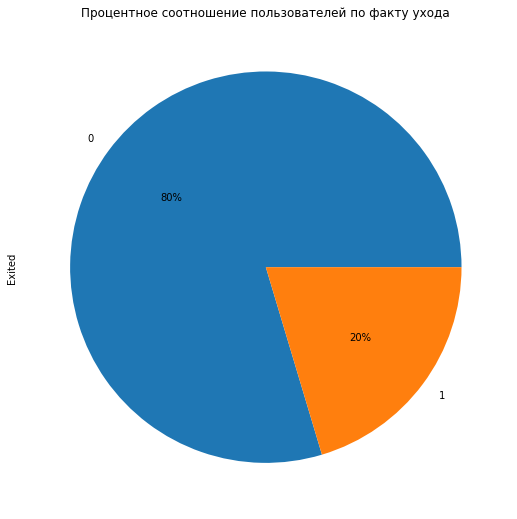

In [260]:
df['Exited'].value_counts().plot( kind = 'pie', y = number_subs_geo,figsize=(9,9), autopct = '%1.0f%%',
title = 'Процентное соотношение пользователей по факту ухода');

Как было проанализировано в первом пункте, 80% пользователей остались, 20% ушли

В теме 4 был показан момент с аргументом class_weight, который помогает сделать классы более сбалансированными. Опробуем на логистической регрессии:

In [261]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('f1:', result)

f1: 0.5091225021720243


In [262]:
best_model = None
best_depth = 0
best_n_estimators = 0
best_result = 0

# Перебор двух гиперпараметров: глубины деревьев и количества деревьев
for depth in tqdm(range(3, 22), desc="Ищем лучший depth"):
    for n_estimators in range(10, 101, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators, class_weight='balanced') 
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_n_estimators = n_estimators

print('F1 лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев для лучшей модели:', best_n_estimators)

Ищем лучший depth: 100%|██████████| 19/19 [01:06<00:00,  3.50s/it]

F1 лучшей модели: 0.638150289017341
Глубина для лучшей модели: 9
Количество деревьев для лучшей модели: 80


Показатель точности ответов увеличился

Сделаем увеличение выборки с помощью upsampled как показано в курсе

In [264]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

positive_count = target_upsampled.sum()
negative_count = len(target_upsampled) - positive_count
print(f'Количество объектов положительного класса: {positive_count}')
print(f'Количество объектов отрицательного класса: {negative_count}')

Количество объектов положительного класса: 4892
Количество объектов отрицательного класса: 4777


In [265]:

best_model = None
best_metrics = (0, 0, 0)  
best_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    f1, precision, recall = calculate_metrics(model, features_valid, target_valid)
    
    if f1 > best_metrics[0]:
        best_model = model
        best_metrics = (f1, precision, recall)
        best_depth = depth

print('Лучшие метрики (F1, Precision, Recall) для лучшей модели:', best_metrics)
print('Глубина для лучшей модели:', best_depth)

Лучшие метрики (F1, Precision, Recall) для лучшей модели: (0.578096947935368, 0.45544554455445546, 0.7911547911547911)
Глубина для лучшей модели: 6


Максимальная доля правильных ответов при 0.578096947935368 и глубине дерева = 6

In [266]:
best_model = None
best_depth = 0
best_n_estimators = 0
best_result = 0

# Перебор двух гиперпараметров: глубины деревьев и количества деревьев
for depth in tqdm(range(3, 22), desc="Ищем лучший depth"):
    for n_estimators in range(10, 101, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators) 
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_n_estimators = n_estimators

print('F1 лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев для лучшей модели:', best_n_estimators)

Ищем лучший depth: 100%|██████████| 19/19 [01:30<00:00,  4.74s/it]

F1 лучшей модели: 0.6418079096045197
Глубина для лучшей модели: 11
Количество деревьев для лучшей модели: 90


Максимальная доля правильных ответов при F1 лучшей модели: 0.6418079096045197
Глубина для лучшей модели: 11
Количество деревьев для лучшей модели: 90

In [267]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('f1:', result)

f1: 0.5086206896551725


Максимальная доля правильных ответов при 0.5086206896551725. 

При upsampled лучше всего оказалась модель RandomForestClassifier с показателем 0.6063100137174211.

Сделаем уменьшение выборки с помощью downsample как показано в курсе

In [268]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

positive_count = target_downsampled.sum()
negative_count = len(target_downsampled) - positive_count
print(f'Количество объектов положительного класса: {positive_count}')
print(f'Количество объектов отрицательного класса: {negative_count}')

Количество объектов положительного класса: 1223
Количество объектов отрицательного класса: 1194


In [269]:

best_model = None
best_metrics = (0, 0, 0)  
best_depth = 0

for depth in range(3, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    f1, precision, recall = calculate_metrics(model, features_valid, target_valid)
    
    if f1 > best_metrics[0]:
        best_model = model
        best_metrics = (f1, precision, recall)
        best_depth = depth

print('Лучшие метрики (F1, Precision, Recall) для лучшей модели:', best_metrics)
print('Глубина для лучшей модели:', best_depth)

Лучшие метрики (F1, Precision, Recall) для лучшей модели: (0.5955734406438632, 0.504258943781942, 0.7272727272727273)
Глубина для лучшей модели: 6


Максимальная доля правильных ответов при 0.5955734406438632 и глубине дерева = 6

In [270]:
best_model = None
best_depth = 0
best_n_estimators = 0
best_result = 0

# Перебор двух гиперпараметров: глубины деревьев и количества деревьев
for depth in tqdm(range(3, 22), desc="Ищем лучший depth"):
    for n_estimators in range(10, 101, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators) 
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_n_estimators = n_estimators

print('F1 лучшей модели:', best_result)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев для лучшей модели:', best_n_estimators)

Ищем лучший depth: 100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

F1 лучшей модели: 0.6187192118226602
Глубина для лучшей модели: 7
Количество деревьев для лучшей модели: 100


Максимальная доля правильных ответов F1 лучшей модели: 0.6187192118226602
Глубина для лучшей модели: 7
Количество деревьев для лучшей модели: 100

In [271]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)

print('f1:', result)

f1: 0.5043029259896729


Максимальная доля правильных ответов при 0.5043029259896729. Данные со взвешиванием практически равны, значит frac определен верно.

Проведена работа с дисбалансом. Проведено увеличение (4) и уменьшение выборки (0.25). Учитывая, что количество оставшихся - 80%, а ушедших - 20%, это верно.

Сделаны функции для downsampled и upsampled.

Проанализирован результат дерева решений, случайного леса и логистической регрессии.

Самой лучшей моделью является случайный лес. Параметры лучшей модели: F1 лучшей модели: 0.6418079096045197 Глубина для лучшей модели: 11 Количество деревьев для лучшей модели: 90

## Тестирование модели

In [273]:
model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=11) 
model.fit(features_upsampled, target_upsampled)
predicted = model.predict(features_test)
result = f1_score(target_test, predicted)
print('f1:', result)

f1: 0.6198439241917504


Удалось достичь f1-меры 0.6198439241917504

Чтобы понять, как сильно модель отличается от случайной, необходимо посчитать площадь под roc-кривой, auc-roc случайной модели равна 0.5.

In [274]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8636880331795586

Значение 0.8636880331795586 близко к 1, что означает, что модель имеет хорошую способность разделять классы и делать верные прогнозы. Чем ближе значение AUC-ROC к 1, тем лучше модель.

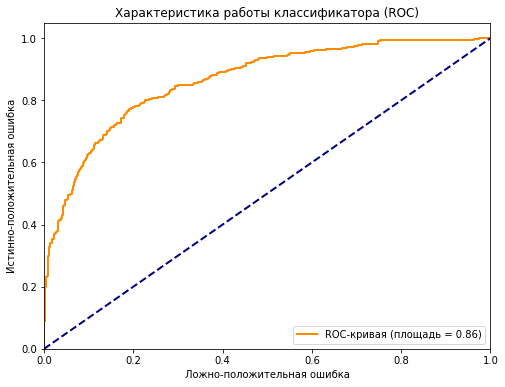

In [275]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно-положительная ошибка')
plt.ylabel('Истинно-положительная ошибка')
plt.title('Характеристика работы классификатора (ROC)')
plt.legend(loc='lower right')
plt.show()

## Вывод



Была загружена и изучена статистика клиентов "Бета-Банка". 

В первом пункте были подготовлены и изучены данные, включая их равномерность и значимость. Были удалены ненужные данные и переформатированы нужные.

Во втором пункте были подготовлены три выборки, также произведено масштабирование признаков, использованы дерево решений, случайный лес и регрессия. 

В третьем пункте были сбалансированы классы. Были написаны функции upsampled и downsampled. был проанализирован результат дерева решений, случайного леса и логистической регрессии. 

Лучшей моделью стал случайный лес с количеством деревьев = 90, глубина = 1.

Затем была протестирована модель с подобранными параметрами. В итоге удалось достичь f1: 0.6198439241917504. AUC-ROC при этом составил 0.8636880331795586.

Цель: спрогнозировать, уйдёт ли клиент из банка в ближайшее время. Для этого необходимо построить модель с предельно большим значением F1-меры, метрику необходимо довести до 0.59. Достигнута.

Все недочеты исправлены, прошу максимально быстро дать ответ по принятию или необходимости доработки проекта. Все необходимые параметры в соответствии с чек-листом и задачами выполнены. 